### Re-implementation of "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning"

Image-based deep learning classifies macular degeneration and diabetic retinopathy using retinal optical coherence tomography (OCT) images and has potential for generalized applications in biomedical image interpretation and medical decision making. Kermany et al., 2018, Cell 172, 1122–1131 February 22, 2018 2018 Elsevier Inc. https://doi.org/10.1016/j.cell.2018.02.010

The paper uses transfer learning, with an InceptionV3 model pre-trained on the ImageNet dataset. 


In [33]:
import os
import time
import numpy as np
import PIL
import PIL.Image
import tqdm

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Flatten, Rescaling 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Imports for MIA
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from scipy import special

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
PATH_TO_DATASET = '../../../../../../research/datasets/ZhangLabData/CellData/OCT'
PATH_TO_TRAIN_DATASET = os.path.join(PATH_TO_DATASET, 'train')
PATH_TO_TEST_DATASET = os.path.join(PATH_TO_DATASET, 'test')

In [3]:
batch_size = 100
epochs = 100

# Max image size for InceptionV3
img_height = 299
img_width = 299

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    PATH_TO_TRAIN_DATASET,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    PATH_TO_TEST_DATASET,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 108309 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.


#### TODO: 
Authors recode the data to have 3 classes instead of 4:
 - CNV & DMR -> urgent referrals
 - Drusen -> routine referrals
 - Normal -> normal

Build a classifier with no 'softmax' activation in the last layer.
The TensorFlow-Privacy MIA implementation requires logits and probabilities.

In [5]:
def build_classifier():
    # InceptionV3 pretrained on ImageNet
    base_model = InceptionV3(include_top=False,
                             weights='imagenet',
                             input_shape=(img_height, img_width, 3),
                             pooling='avg'
                            )
    # Freeze parameters
    base_model.trainable = False
    
    # Model definition
    input_data = Input(shape=(img_height, img_width, 3))
    # InceptionV3 expects pixel data in range [-1,1]
    x = Rescaling(1./127.5, offset=-1)(input_data)
    x = base_model(x, training=False)
    # No softmax
    output = Dense(num_classes)(x)

    model = Model(inputs=input_data, outputs=output)
    
    # Loss function from logits
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam',
                  loss=loss,
                  metrics=['accuracy'],
                 )
    
    return model

In [8]:
classifier = build_classifier()
classifier.summary()

# Train network until convergence 
early_stopping = EarlyStopping(monitor='accuracy', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
r = classifier.fit(train_ds,
                   epochs=epochs,
                   validation_data=test_ds,
                   verbose=1,
                   callbacks=[early_stopping, reduce_lr]
                  )   

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
1084/1084 [==============================] - 389s 356ms/step - loss: 0.3974 - accuracy: 0.8629 - val_loss: 0.3001 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 2/100
1

Epoch 45/100
1084/1084 [==============================] - 225s 208ms/step - loss: 0.2110 - accuracy: 0.9276 - val_loss: 0.2394 - val_accuracy: 0.9120 - lr: 1.0000e-05
Epoch 46/100
1084/1084 [==============================] - 225s 208ms/step - loss: 0.2110 - accuracy: 0.9277 - val_loss: 0.2393 - val_accuracy: 0.9120 - lr: 1.0000e-05
Epoch 47/100
1084/1084 [==============================] - 226s 208ms/step - loss: 0.2110 - accuracy: 0.9277 - val_loss: 0.2385 - val_accuracy: 0.9120 - lr: 1.0000e-05
Epoch 48/100
1084/1084 [==============================] - 229s 211ms/step - loss: 0.2110 - accuracy: 0.9275 - val_loss: 0.2394 - val_accuracy: 0.9120 - lr: 1.0000e-05
Epoch 49/100
1084/1084 [==============================] - 232s 213ms/step - loss: 0.2110 - accuracy: 0.9276 - val_loss: 0.2401 - val_accuracy: 0.9120 - lr: 1.0000e-05
Epoch 50/100
1084/1084 [==============================] - 229s 211ms/step - loss: 0.2109 - accuracy: 0.9276 - val_loss: 0.2400 - val_accuracy: 0.9120 - lr: 1.0000e-0

1084/1084 [==============================] - 230s 212ms/step - loss: 0.2104 - accuracy: 0.9279 - val_loss: 0.2398 - val_accuracy: 0.9130 - lr: 1.0000e-05
Epoch 95/100
1084/1084 [==============================] - 234s 216ms/step - loss: 0.2103 - accuracy: 0.9278 - val_loss: 0.2391 - val_accuracy: 0.9130 - lr: 1.0000e-05
Epoch 96/100
1084/1084 [==============================] - 236s 217ms/step - loss: 0.2103 - accuracy: 0.9278 - val_loss: 0.2406 - val_accuracy: 0.9130 - lr: 1.0000e-05
Epoch 97/100
1084/1084 [==============================] - 238s 219ms/step - loss: 0.2103 - accuracy: 0.9279 - val_loss: 0.2407 - val_accuracy: 0.9130 - lr: 1.0000e-05
Epoch 98/100
1084/1084 [==============================] - 238s 219ms/step - loss: 0.2103 - accuracy: 0.9279 - val_loss: 0.2407 - val_accuracy: 0.9130 - lr: 1.0000e-05
Epoch 99/100
1084/1084 [==============================] - 226s 208ms/step - loss: 0.2103 - accuracy: 0.9278 - val_loss: 0.2393 - val_accuracy: 0.9130 - lr: 1.0000e-05
Epoch 100/1

In [13]:
from datetime import datetime
classifier.save('OCT-Kermany-'+datetime.now().strftime('%Y%m%d-%H.%M'))

INFO:tensorflow:Assets written to: OCT-Kermany-20220118-17.01\assets


In [ ]:
# To retrieve saved model
# model = keras.models.load_model('OCT-Kermany-model-datetime')

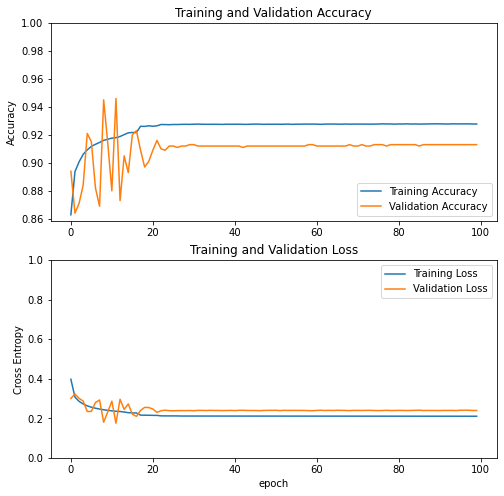

In [9]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [10]:
y_pred = np.array([])
y_true = np.array([])
for x, y in test_ds:
    y_true = np.concatenate((y_true, np.argmax(y,axis=1)),axis=0)
    y_pred = np.concatenate((y_pred, np.argmax(classifier.predict(x),axis=1)),axis=0) 

In [11]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

         CNV     0.8294    0.9720    0.8950       250
         DME     0.9305    0.9640    0.9470       250
      DRUSEN     0.9946    0.7360    0.8460       250
      NORMAL     0.9316    0.9800    0.9552       250

    accuracy                         0.9130      1000
   macro avg     0.9215    0.9130    0.9108      1000
weighted avg     0.9215    0.9130    0.9108      1000



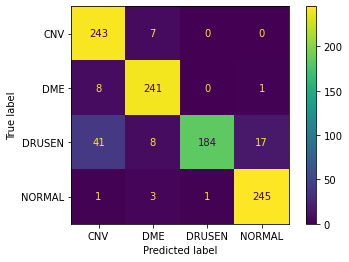

In [12]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

## Membership inference attack using TF-Privacy
The inputs to the function are the train and test features and labels, along with the trained model.

The function internally computes the probabilities from the logits, using the softmax function.

`SlicingSpec` configures how the data is used to run the attacks. In the example below, the attacks will be performed on the whole dataset, on individual classes, and on correctly/incorrectly classified instances. 
`attack_types` tells the engine what type of MIA are to be run: for example, the threshold attack works on the assumption that the classification loss for member instances will be smaller than that of the non-member instances. The MLP attack builds shadow models as the Shokri attack.

In [31]:
def membership_inference_attack(model, train_ds, test_ds):
    
    print('Predict on train...')
    logits_train = np.empty((0,4))
    y_train = np.empty((0,4))
    for x, y in tqdm.tqdm(train_ds):
        logits_train = np.concatenate((logits_train, model.predict(x)),axis=0)
        y_train = np.concatenate((y_train, y),axis=0)

    print('Predict on test...')
    logits_test = np.empty((0,4))
    y_test = np.empty((0,4))
    for x, y in tqdm.tqdm(test_ds):
        logits_test = np.concatenate((logits_test, model.predict(x)),axis=0)
        y_test = np.concatenate((y_test, y),axis=0)

    print('Apply softmax to get probabilities from logits...')
    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    print('Compute losses...')
    cce = tf.keras.backend.categorical_crossentropy
    constant = tf.keras.backend.constant

    loss_train = cce(constant(y_train), constant(prob_train), from_logits=False).numpy()
    loss_test = cce(constant(y_test), constant(prob_test), from_logits=False).numpy()
    
    labels_train = np.argmax(y_train, axis=1)
    labels_test = np.argmax(y_test, axis=1)

    input = AttackInputData(
      logits_train = logits_train,
      logits_test = logits_test,
      loss_train = loss_train,
      loss_test = loss_test,
      labels_train = labels_train,
      labels_test = labels_test
    )

    # Run several attacks for different data slices
    attacks_result = mia.run_attacks(input,
                                     SlicingSpec(
                                         entire_dataset = True,
                                         by_class = True,
                                         by_classification_correctness = True
                                     ),
                                     attack_types = [
                                         AttackType.THRESHOLD_ATTACK,
                                         AttackType.LOGISTIC_REGRESSION,
                                         AttackType.MULTI_LAYERED_PERCEPTRON,
                                         AttackType.RANDOM_FOREST, 
                                         AttackType.K_NEAREST_NEIGHBORS,
                                         AttackType.THRESHOLD_ENTROPY_ATTACK
                                     ])

    # Plot the ROC curve of the best classifier
    fig = plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)

    # Print a user-friendly summary of the attacks
    print(attacks_result.summary(by_slices = True))
    return attacks_result.get_result_with_max_auc().get_auc(), attacks_result.get_result_with_max_attacker_advantage().get_attacker_advantage()

Predict on train...


100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [05:04<00:00,  3.56it/s]


Predict on test...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.94it/s]


Apply softmax to get probabilities from logits...
Compute losses...


C:\Users\Usuario\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Usuario\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Usuario

Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Best-performing attacks over all slices
  RANDOM_FOREST (with 250 training and 250 test examples) achieved an AUC of 0.78 on slice CLASS=1
  MULTI_LAYERED_PERCEPTRON (with 250 training and 250 test examples) achieved an advantage of 0.50 on slice CLASS=0

Best-performing attacks over slice: "Entire dataset"
  RANDOM_FOREST (with 1000 training and 1000 test examples) achieved an AUC of 0.74
  RANDOM_FOREST (with 1000 training and 1000 test examples) achieved an advantage of 0.40

Best-performing attacks over slice: "CLASS=0"
  MULTI_LAYERED_PERCEPTRON (with 250 training and 250 test examples) achieved an AUC of 0.76
  MULTI_LAYERED_PERCEPTRON (with 250 training and 250 test examples) achieved an advantage of 0.50

Best-performing attacks over slice: "CLASS=1"
  R

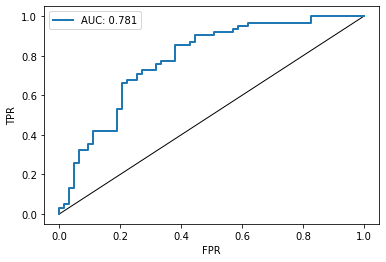

In [34]:
auc, adv = membership_inference_attack(classifier, train_ds, test_ds)